In [2]:
import csv
import pandas
import numpy as np
import matplotlib.pyplot as plt

c:\Users\Sebyb\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Sebyb\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Sebyb\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [11]:
# Read the data from the CSV file
filename = 'ablation_results/ablation_fold_details_2.csv'
data = pandas.read_csv(filename)


# Split hyperparameters into separate columns from dict, with keys as column names
data = data.join(data['Hyperparameters'].apply(eval).apply(pandas.Series))

# Convert to dataframe
data = pandas.DataFrame(data)

# Convert all column names to lower case and remove spaces with _
data.columns = data.columns.str.lower().str.replace(' ', '_')
print(data.columns)

# Apply eval to the train and val losses columns
data['train_losses'] = data['train_losses'].apply(eval)
data['val_losses'] = data['val_losses'].apply(eval)

print(data.head(1))

Index(['fold', 'hyperparameters', 'train_losses', 'val_losses', 'val_accuracy',
       'val_precision', 'val_recall', 'val_f1', 'time_taken',
       'early_stop_epoch', 'epochs', 'lr', 'bn', 'batch_size', 'dropout_rate',
       'hidden_layers', 'activations', 'input_size', 'weight_decay',
       'optimiser', 'early_stopping'],
      dtype='object')
   fold                                    hyperparameters  \
0     1  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   

                                        train_losses  \
0  [1.7113987304000648, 1.5396676650237835, 1.479...   

                                          val_losses  val_accuracy  \
0  [1.7549325091741776, 1.7033430330054082, 1.671...        0.4252   

   val_precision  val_recall   val_f1  time_taken  early_stop_epoch  ...  \
0       0.428593    0.428503  0.41148   24.066002              19.0  ...   

      lr  bn  batch_size  dropout_rate  hidden_layers            activations  \
0  0.001   0           4     [0, 0, 0

In [102]:
print(data.columns)
# Columns: ['fold', 'hyperparameters', 'train_losses', 'val_losses', 'val_accuracy','val_precision', 'val_recall', 'val_f1', 'time_taken','early_stop_epoch', 'epochs', 'lr', 'bn', 'batch_size', 'dropout_rate','hidden_layers', 'activations', 'input_size', 'weight_decay','optimiser', 'early_stopping']

Index(['fold', 'hyperparameters', 'train_losses', 'val_losses', 'val_accuracy',
       'val_precision', 'val_recall', 'val_f1', 'time_taken',
       'early_stop_epoch', 'epochs', 'lr', 'bn', 'batch_size', 'dropout_rate',
       'hidden_layers', 'activations', 'input_size', 'weight_decay',
       'optimiser', 'early_stopping'],
      dtype='object')


[[1.71139873e+000 1.53966767e+000 1.47969627e+000 1.40743272e+000
  1.39747641e+000 1.37984252e+000 1.33553128e+000 1.35533117e+000
  1.34845115e+000 1.32164582e+000 1.30296344e+000 1.30891648e+000
  1.30247232e+000 1.31352865e+000 1.28691042e+000 1.30384978e+000
  1.30749765e+000 1.28542162e+000 1.27988216e+000 1.11297875e-311
  1.11297875e-311 1.11297875e-311 1.11297875e-311 1.11297875e-311
  1.11204318e-311 1.11204318e-311 1.11204318e-311 1.11204318e-311
  1.11204318e-311 1.11204318e-311 1.11204318e-311 1.11204318e-311
  1.11204318e-311 1.11204318e-311 1.11204318e-311 1.11204318e-311
  1.11204318e-311 1.11204318e-311 1.11204318e-311 1.11204318e-311
  1.11204318e-311 1.11204318e-311 1.11204318e-311 1.11204318e-311
  1.11204318e-311 1.11204318e-311 1.11204318e-311 1.11204318e-311
  1.11204318e-311 1.11204318e-311]
 [1.74458538e+000 1.52166107e+000 1.45080681e+000 1.42518761e+000
  1.38943090e+000 1.37725722e+000 1.36118514e+000 1.34273881e+000
  1.32608852e+000 1.31272372e+000 1.31131

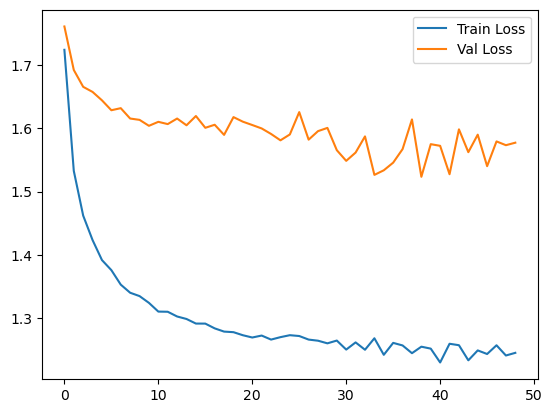

In [57]:
# Collate the first 10 train losses into a list
train_losses = np.ndarray(shape=(10, 50))
for i in range(10):
    # Fill the ith row with the train losses of the ith fold filling with zeros if the length is less than 50
    train_losses[i, :len(data.iloc[i]['train_losses'])] = data.iloc[i]['train_losses']

# Collate the first 10 val losses into a list
val_losses = np.ndarray(shape=(10, 50))
for i in range(10):
    val_losses[i, :len(data.iloc[i]['val_losses'])] = data.iloc[i]['val_losses']
    
    
# Create an average of the first 10 train losses between the folds, dividing each element by the number of non-zero elements
# train_losses_avg = np.sum(train_losses, axis=0) / np.sum(train_losses != 0, axis=0)
# val_losses_avg = np.sum(val_losses, axis=0) / np.sum(val_losses != 0, axis=0)

print(train_losses)
print(np.sum(train_losses, axis=0))
print(np.sum(train_losses != 0, axis=0))
print(np.sum(train_losses, axis=0) / np.sum(train_losses != 0, axis=0))

# print(train_losses_avg)
# print(train_losses_avg)
# print(val_losses_avg)

# Plot the average train and val losses over the epochs (iterations/index in the array)
plt.plot(train_losses_avg, label='Train Loss')
plt.plot(val_losses_avg, label='Val Loss')
plt.legend()
plt.show()

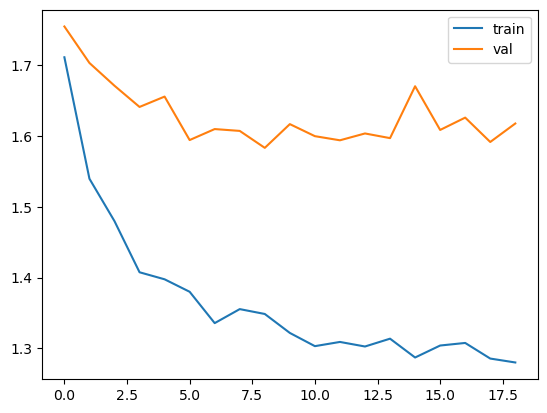

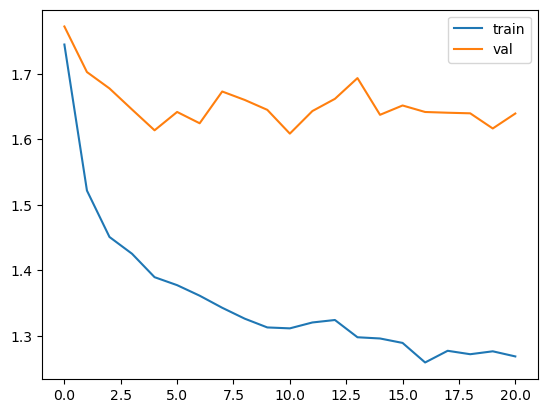

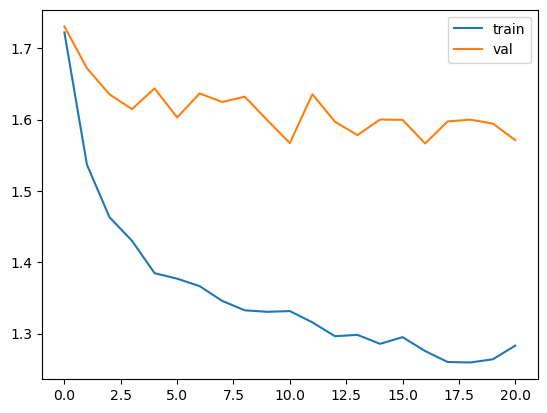

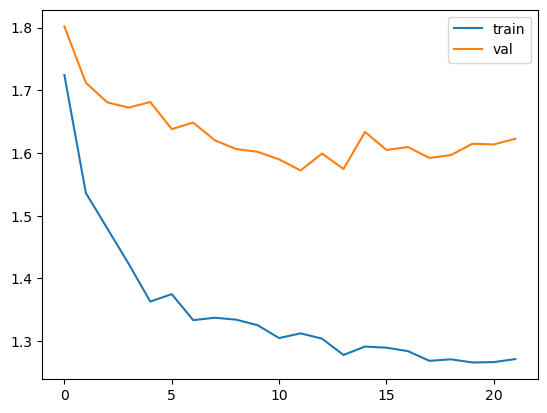

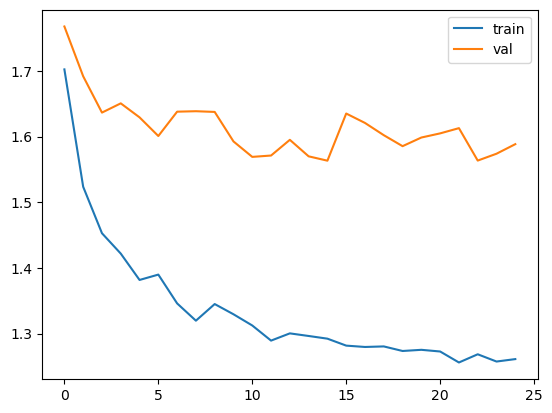

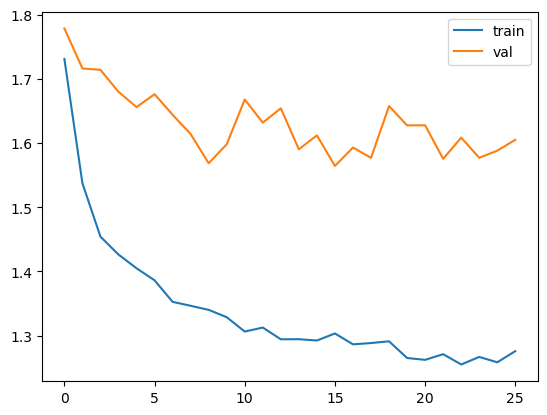

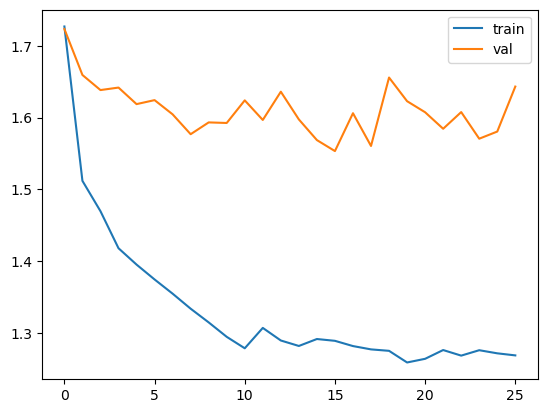

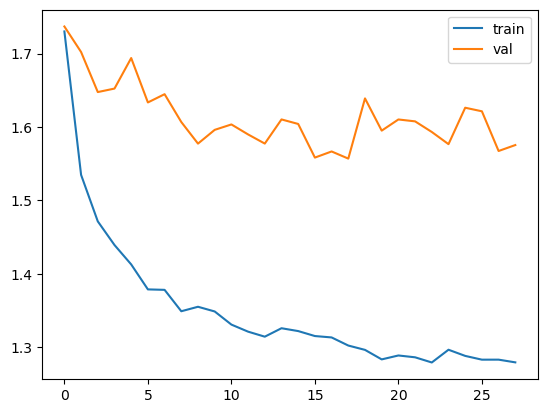

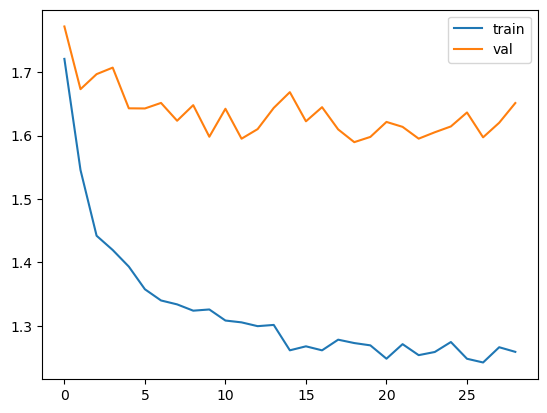

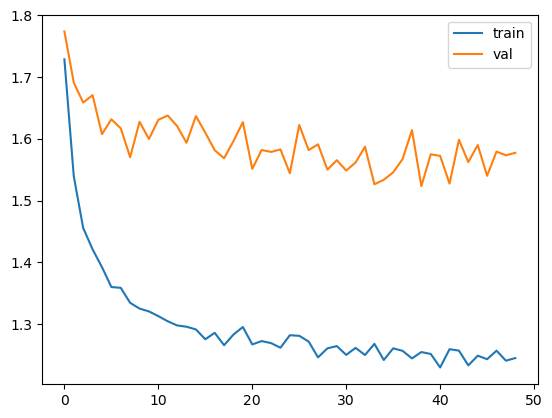

In [34]:
# Plot the training and validation losses of the first 10 folds / rows against the epoch / iteration
for i in range(10):
    plt.plot(data.iloc[i]['train_losses'], label='train')
    plt.plot(data.iloc[i]['val_losses'], label='val')
    plt.legend()
    plt.show()


In [12]:
# set first 10 rows as data_baseline
data_baseline = data.iloc[:10]
print(data_baseline.head())

# Find the folds with the str typecast of activations equals the string ['None', 'tanh', 'softmax']
data_activations_tanh = data[data['activations'].astype(str) == "['None', 'tanh', 'softmax']"]
data_activations_logistic = data[data['activations'].astype(str) == "['None', 'logistic', 'softmax']"]
#print(data_activations_tanh)
#print(data_activations_logistic)
# Print unique values of the activations column
# print(str(data['activations'][189]) == "['None', 'tanh', 'softmax']")

   fold                                    hyperparameters  \
0     1  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
1     2  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
2     3  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
3     4  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   
4     5  {"epochs": 50, "lr": 0.001, "bn": 0, "batch_si...   

                                        train_losses  \
0  [1.7113987304000648, 1.5396676650237835, 1.479...   
1  [1.7445853833215577, 1.5216610663477723, 1.450...   
2  [1.7222205131028074, 1.536660601951376, 1.4631...   
3  [1.7243256621552023, 1.5362251940585308, 1.479...   
4  [1.7022237001015417, 1.5235164595580077, 1.452...   

                                          val_losses  val_accuracy  \
0  [1.7549325091741776, 1.7033430330054082, 1.671...        0.4252   
1  [1.7721356957213916, 1.7025712225679184, 1.677...        0.4296   
2  [1.7304820942775772, 1.6720130368518002, 1.635...        0.4520   
3  [1.8018

In [17]:
# Function to create average train and val losses across the folds for a given dataframe
def create_avg_train_val_losses(data):
    # Collate the first 10 train losses into a list
    train_losses = np.ndarray(shape=(10, 50))
    for i in range(10):
        # Fill the ith row with the train losses of the ith fold filling with zeros if the length is less than 50
        train_losses[i, :len(data.iloc[i]['train_losses'])] = data.iloc[i]['train_losses']

    # Collate the first 10 val losses into a list
    val_losses = np.ndarray(shape=(10, 50))
    for i in range(10):
        val_losses[i, :len(data.iloc[i]['val_losses'])] = data.iloc[i]['val_losses']

    # Create an average of the first 10 train losses between the folds, dividing each element by the number of non-zero elements
    train_losses_avg = np.sum(train_losses, axis=0) / np.sum(train_losses != 0, axis=0)
    val_losses_avg = np.sum(val_losses, axis=0) / np.sum(val_losses != 0, axis=0)
    return train_losses_avg, val_losses_avg

In [16]:
# Create the average train and val losses for the baseline data
train_losses_avg_baseline, val_losses_avg_baseline = create_avg_train_val_losses(data_baseline)

# Create the average train and val losses for the tanh activation data
train_losses_avg_tanh, val_losses_avg_tanh = create_avg_train_val_losses(data_activations_tanh)

# Create the average train and val losses for the logistic activation data
train_losses_avg_logistic, val_losses_avg_logistic = create_avg_train_val_losses(data_activations_logistic)

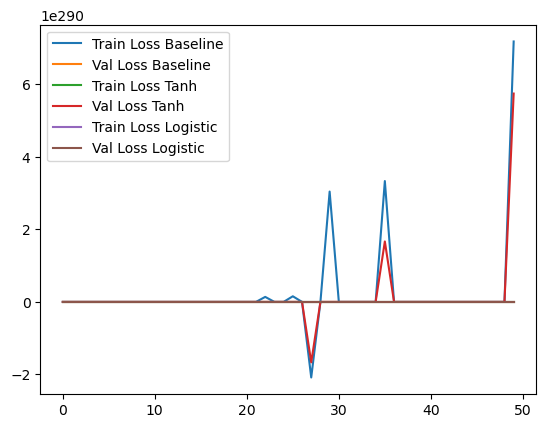

In [15]:
# Plot the average train and val losses over the epochs (iterations/index in the array)
plt.plot(train_losses_avg_baseline, label='Train Loss Baseline')
plt.plot(val_losses_avg_baseline, label='Val Loss Baseline')
plt.plot(train_losses_avg_tanh, label='Train Loss Tanh')
plt.plot(val_losses_avg_tanh, label='Val Loss Tanh')
plt.plot(train_losses_avg_logistic, label='Train Loss Logistic')
plt.plot(val_losses_avg_logistic, label='Val Loss Logistic')
plt.legend()

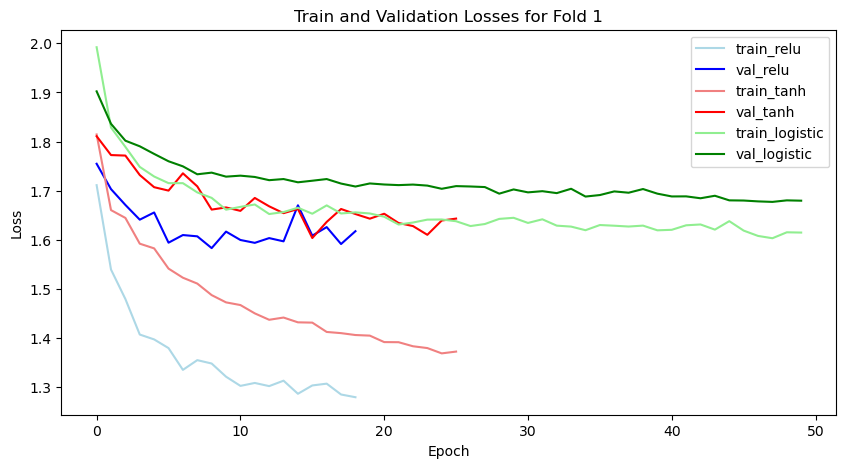

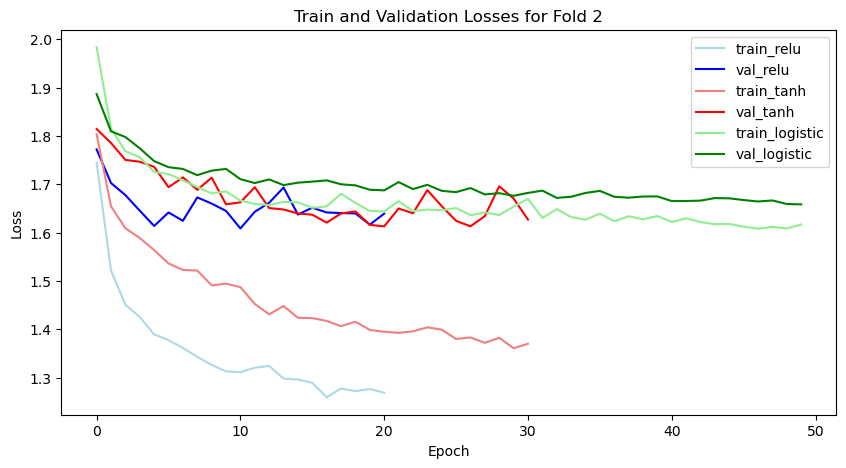

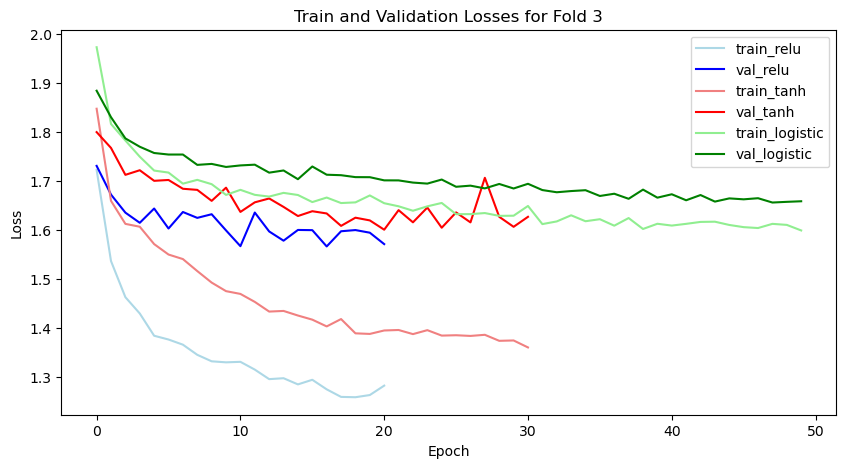

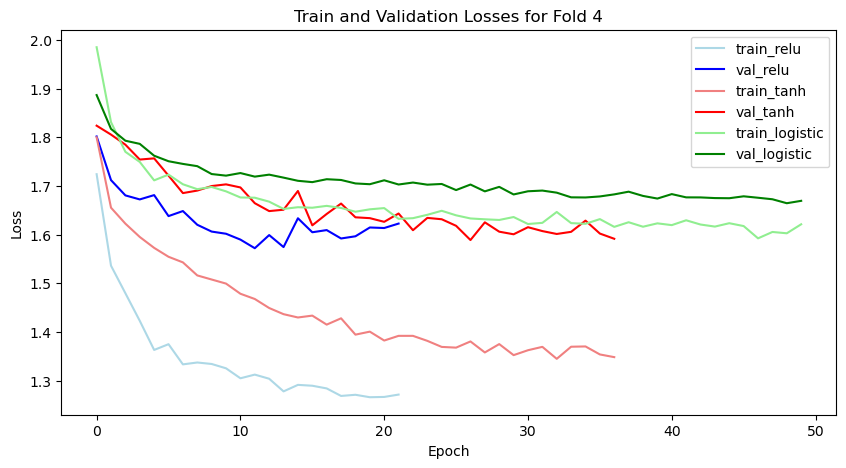

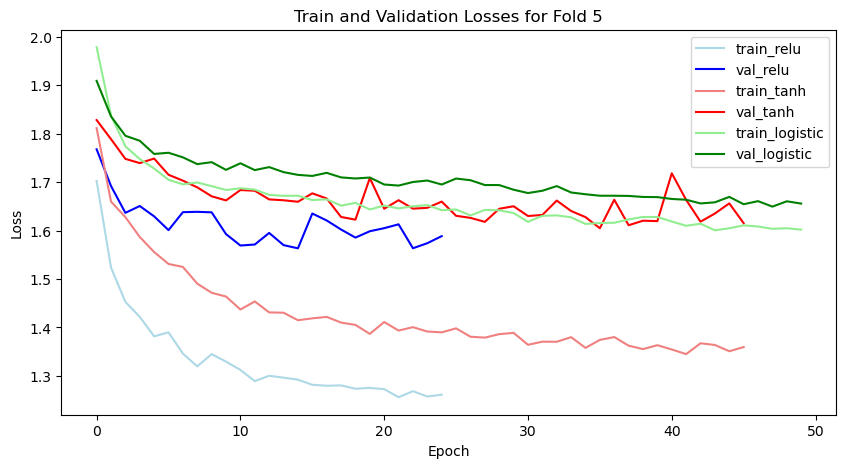

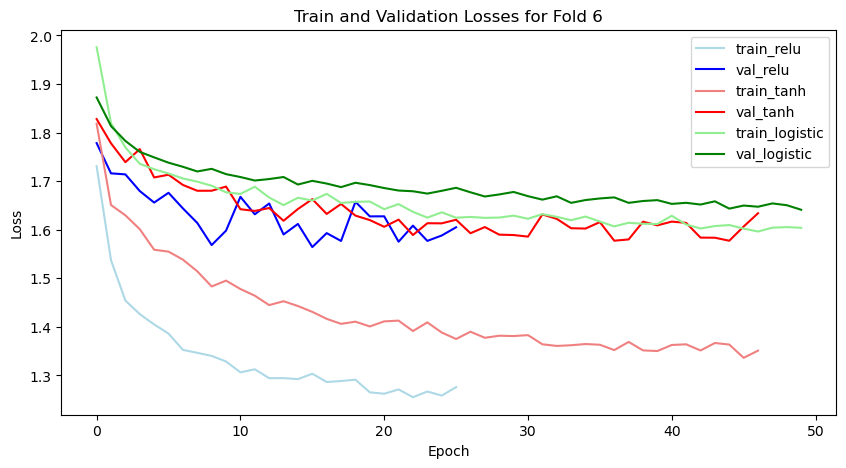

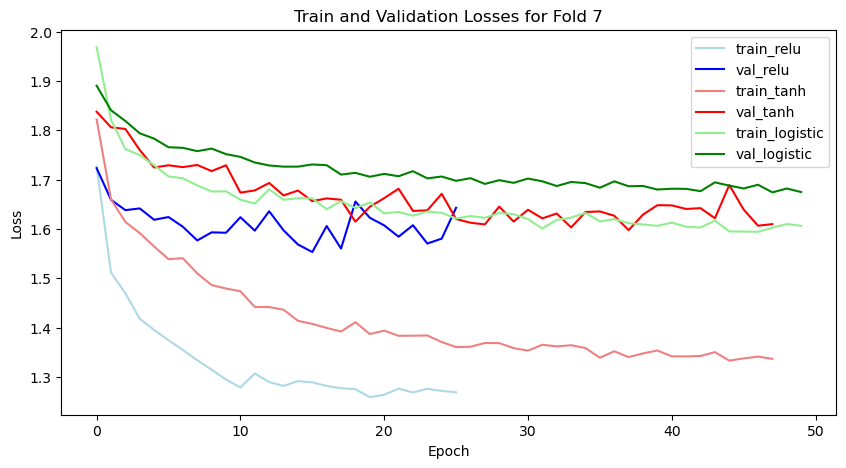

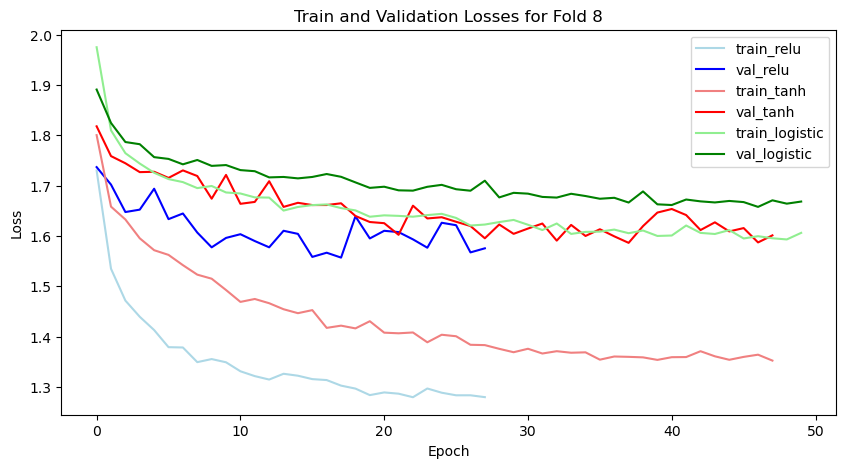

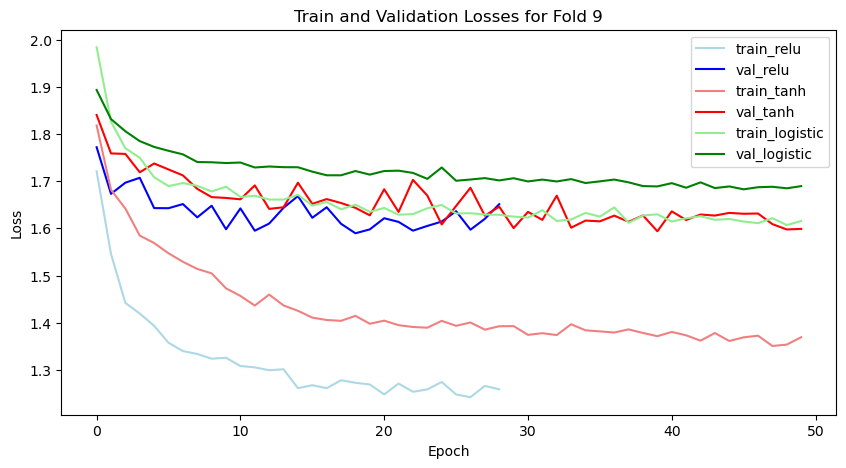

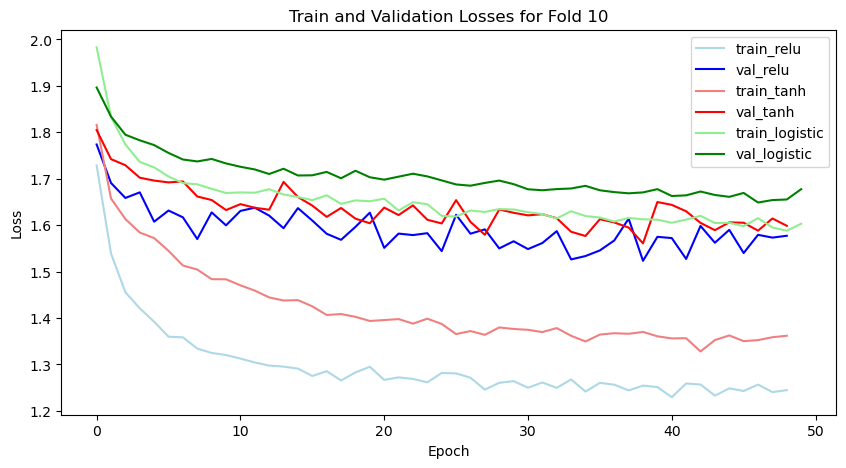

In [99]:
# Graph the average training and validation losses of the baseline and the activation functions tanh and logistic
# 2 hues of the same color for each of the train and val losses per activation function. eg. relu blue and light blue, tanh red and light red, logistic green and light green
for i in range(10):
    # Set plot size
    plt.figure(figsize=(10, 5))
    # Set plot title and axis labels
    plt.title('Train and Validation Losses for Fold ' + str(i+1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # Plot the training and validation losses for the baseline, tanh and logistic activation functions
    plt.plot(data_baseline.iloc[i]['train_losses'], label='train_relu', color='lightblue')
    plt.plot(data_baseline.iloc[i]['val_losses'], label='val_relu', color='blue')
    plt.plot(data_activations_tanh.iloc[i]['train_losses'], label='train_tanh', color='lightcoral')
    plt.plot(data_activations_tanh.iloc[i]['val_losses'], label='val_tanh', color='red')
    plt.plot(data_activations_logistic.iloc[i]['train_losses'], label='train_logistic', color='lightgreen')
    plt.plot(data_activations_logistic.iloc[i]['val_losses'], label='val_logistic', color='green')
    plt.legend()
    plt.show()

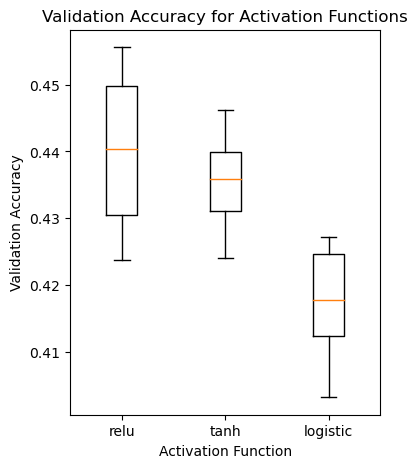

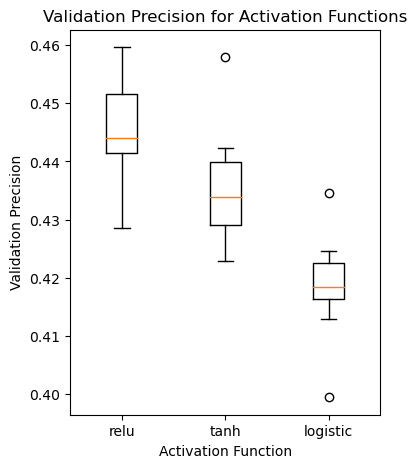

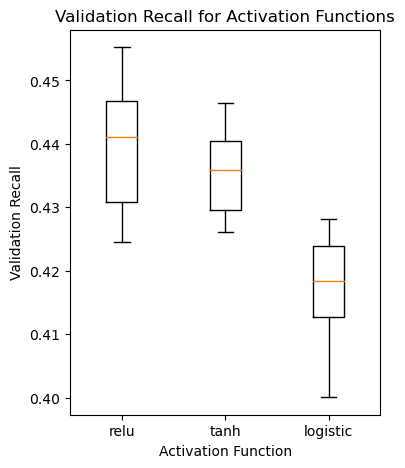

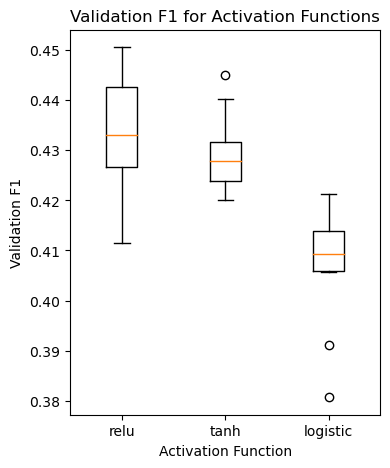

In [109]:
# Boxplot of each activation function per metric (val_accuracy, val_precision, val_recall, val_f1)

plt.figure(figsize=(4, 5))
plt.title('Validation Accuracy for Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('Validation Accuracy')
plt.boxplot([data_baseline['val_accuracy'], data_activations_tanh['val_accuracy'], data_activations_logistic['val_accuracy']], labels=['relu', 'tanh', 'logistic'])
plt.show()

plt.figure(figsize=(4, 5))
plt.title('Validation Precision for Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('Validation Precision')
plt.boxplot([data_baseline['val_precision'], data_activations_tanh['val_precision'], data_activations_logistic['val_precision']], labels=['relu', 'tanh', 'logistic'])
plt.show()

plt.figure(figsize=(4, 5))
plt.title('Validation Recall for Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('Validation Recall')
plt.boxplot([data_baseline['val_recall'], data_activations_tanh['val_recall'], data_activations_logistic['val_recall']], labels=['relu', 'tanh', 'logistic'])
plt.show()

plt.figure(figsize=(4, 5))
plt.title('Validation F1 for Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('Validation F1')
plt.boxplot([data_baseline['val_f1'], data_activations_tanh['val_f1'], data_activations_logistic['val_f1']], labels=['relu', 'tanh', 'logistic'])
plt.show()

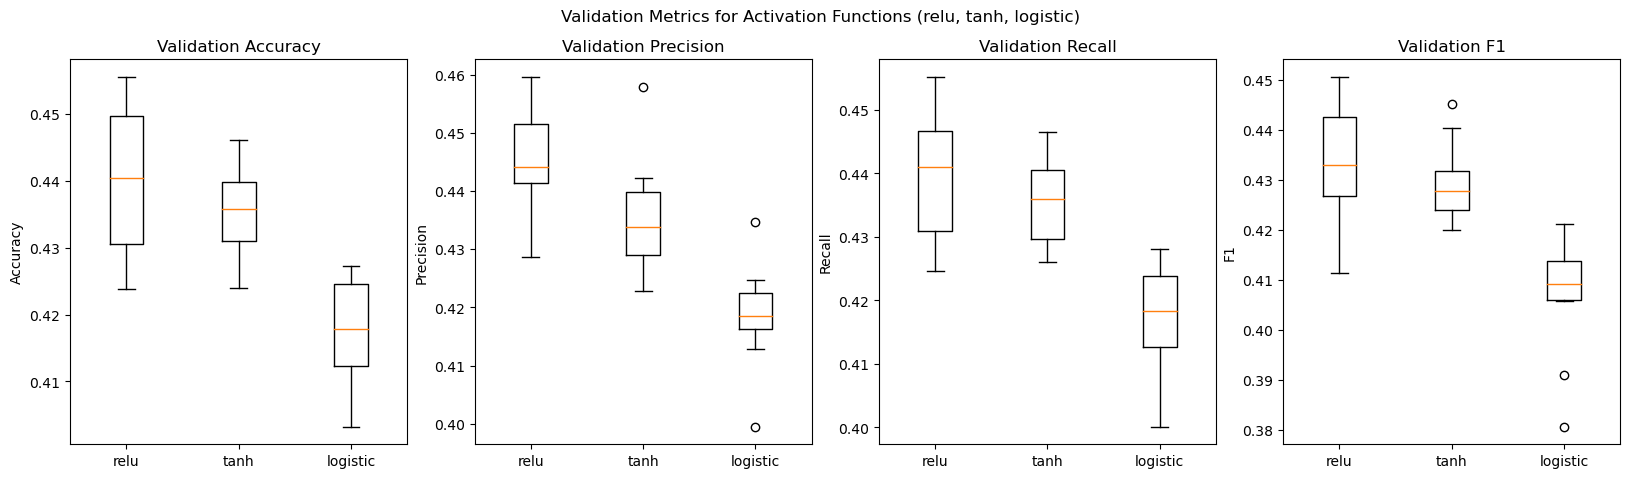

In [125]:
# Group plots for each metric (val_accuracy, val_precision, val_recall, val_f1) into a single figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Validation Metrics for Activation Functions (relu, tanh, logistic)')
# Align labels of y-axis for all subplots, only show the label for the first subplot
# Plot the boxplots for each metric in each subplot
axs[0].set_title('Validation Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].boxplot([data_baseline['val_accuracy'], data_activations_tanh['val_accuracy'], data_activations_logistic['val_accuracy']], labels=['relu', 'tanh', 'logistic'])
axs[1].set_title('Validation Precision')
axs[1].set_ylabel('Precision')
axs[1].boxplot([data_baseline['val_precision'], data_activations_tanh['val_precision'], data_activations_logistic['val_precision'],], labels=['relu', 'tanh', 'logistic'])
axs[2].set_title('Validation Recall')
axs[2].set_ylabel('Recall')
axs[2].boxplot([data_baseline['val_recall'], data_activations_tanh['val_recall'], data_activations_logistic['val_recall'],], labels=['relu', 'tanh', 'logistic'])
axs[3].set_title('Validation F1')
axs[3].set_ylabel('F1')
axs[3].boxplot([data_baseline['val_f1'], data_activations_tanh['val_f1'], data_activations_logistic['val_f1'],], labels=['relu', 'tanh', 'logistic'])
plt.show()